In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib.dates as mdates
import ast

### Analisando base de dados

In [2]:
df_sp = pd.read_csv("../database/combined_data.csv", sep=';')

In [3]:
produtos_filtrados = ['etanolhidratado', 'gasolinac', 'glp', 'oleodiesel', 'querosenedeaviacao']
df_sp = df_sp[(df_sp['state'] == 'sp') & (df_sp['product'].isin(produtos_filtrados))]

In [4]:
# Dicionário de substituições
substituicoes = {
    'etanolhidratado': 'Etanol Hidratado',
    'gasolinac': 'Gasolina Comum',
    'glp': 'GLP',
    'oleodiesel': 'Óleo Diesel',
    'querosenedeaviacao': 'Querosene de Aviação'
}

# Renomear os valores na coluna 'product'
df_sp['product'] = df_sp['product'].replace(substituicoes)

datetime64[ns]


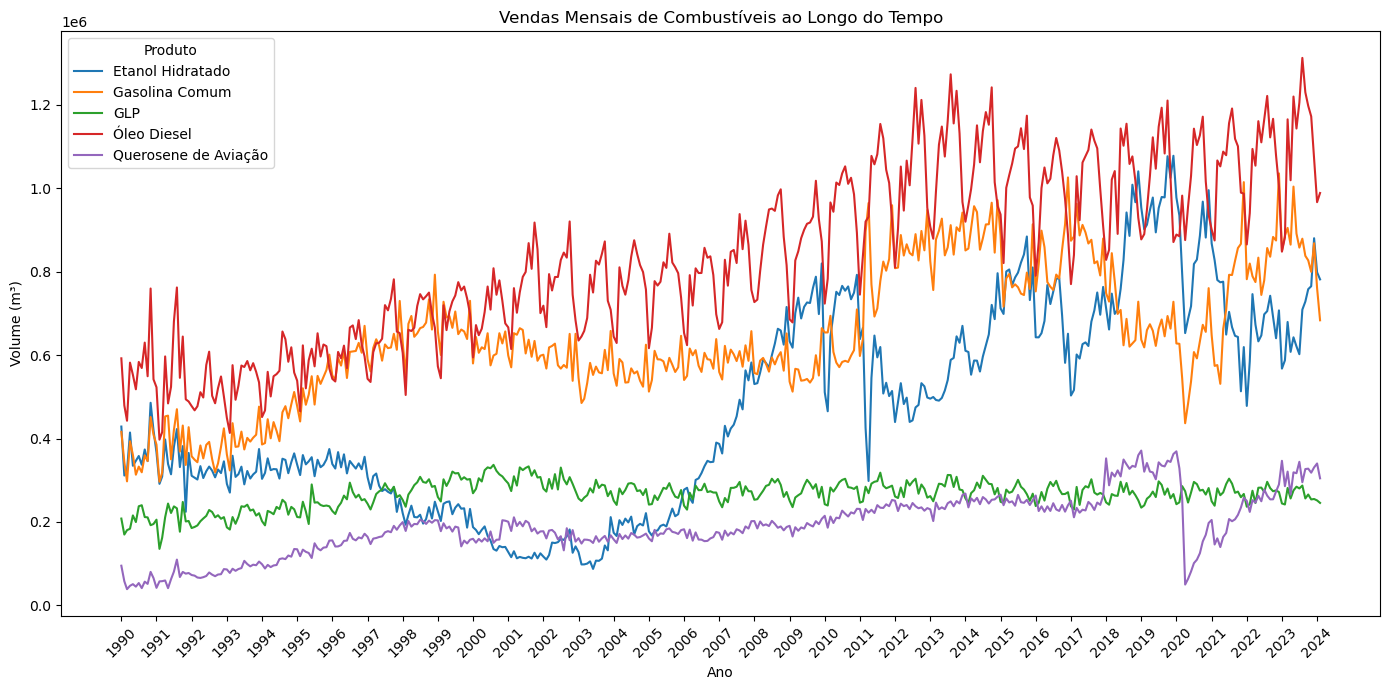

In [5]:
# Converter 'timestamp' para o formato datetime
df_sp['timestamp'] = pd.to_datetime(df_sp['timestamp'], errors='coerce')  # Usar 'coerce' para lidar com valores inválidos

# Verificar se a conversão foi bem-sucedida (opcional, mas útil para depuração)
print(df_sp['timestamp'].dtypes)

# Criar o gráfico de linhas
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_sp, x='timestamp', y='m3', hue='product')

# Ajustar título e rótulos
plt.title('Vendas Mensais de Combustíveis ao Longo do Tempo')
plt.xlabel('Ano')
plt.ylabel('Volume (m³)')

# Extrair anos únicos para o eixo x
unique_years = df_sp['timestamp'].dt.year.dropna().unique()  # Garantir que não há valores nulos
plt.xticks(ticks=[pd.Timestamp(f'{year}-01-01') for year in unique_years], labels=unique_years, rotation=45)

plt.legend(title='Produto')
plt.tight_layout()  # Ajustar layout para evitar sobreposição
plt.show()

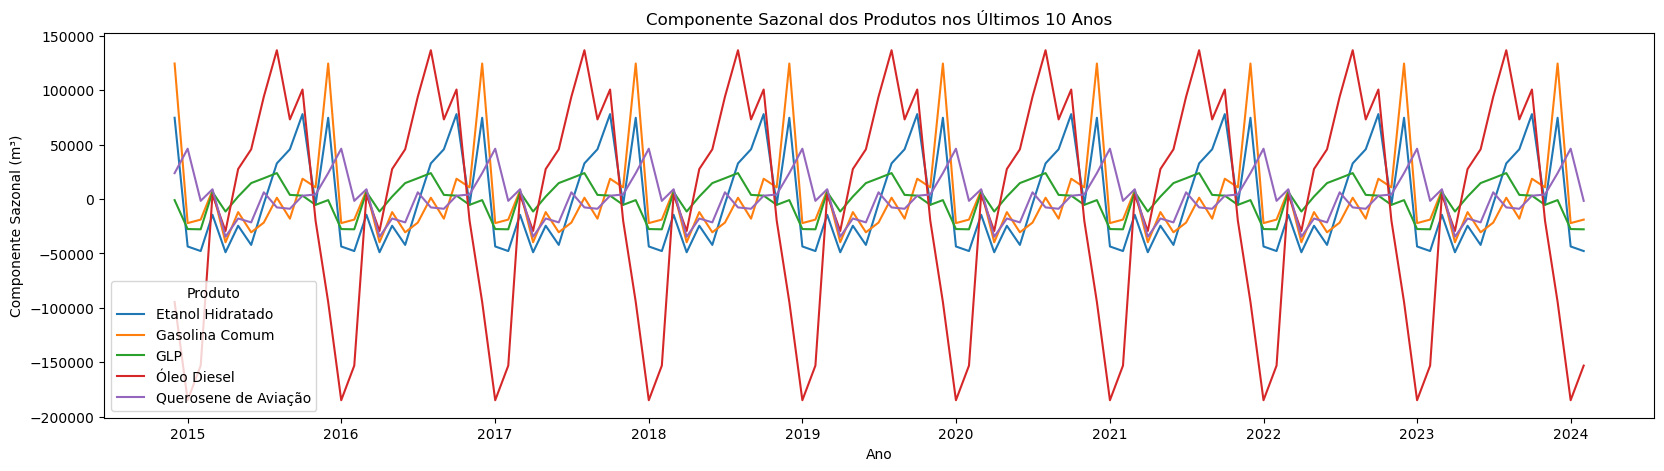

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Filtrar os últimos 10 anos
df_filtered = df_sp[df_sp['timestamp'] >= pd.Timestamp.now() - pd.DateOffset(years=10)]

# Calcular a sazonalidade usando a decomposição
def decompose_and_plot(product_data):
    result = seasonal_decompose(product_data['m3'], model='additive', period=12)
    seasonal = result.seasonal
    return seasonal

# Criar um DataFrame para os componentes sazonais
seasonal_components = pd.DataFrame()

for product in df_filtered['product'].unique():
    product_data = df_filtered[df_filtered['product'] == product].set_index('timestamp')
    seasonal = decompose_and_plot(product_data)
    seasonal_components[product] = seasonal

# Resetar o índice para plotagem
seasonal_components.reset_index(inplace=True)
seasonal_components.rename(columns={'index': 'timestamp'}, inplace=True)

# Plotar o gráfico
plt.figure(figsize=(20, 5))
sns.lineplot(data=seasonal_components.melt(id_vars='timestamp', var_name='product', value_name='seasonal'),
             x='timestamp', y='seasonal', hue='product')
plt.title('Componente Sazonal dos Produtos nos Últimos 10 Anos')
plt.xlabel('Ano')
plt.ylabel('Componente Sazonal (m³)')
plt.legend(title='Produto')
plt.show()

### Carregando dados

In [7]:
df = pd.read_excel("../LSTM/result_12/lstm_results.xlsx")
df_diff = pd.read_excel("../LSTM/result_12/lstm_results_diff.xlsx")
df_bi = pd.read_excel("../LSTM/result_12/lstm_results_bilstm.xlsx") 
df_features = pd.read_excel("../LSTM/result_12/lstm_results_CATCH22.xlsx") 
df_simples = pd.read_excel("../LSTM/result_12/lstm_results_simples.xlsx") 
df_torch = pd.read_excel("../LSTM/result_12/lstm_results_pytorch.xlsx") 
df_5anos = pd.read_csv("../LSTM/result_12/Plat_Metricas_5years_Output.csv") 
df_comp = pd.read_excel("../00-RANKING.xlsx")
df_comp_real = pd.read_csv("../Prophet_12_output.csv", header=None)
df_time_moe = pd.read_excel("../LSTM/result_12/lstm_results_time_moe.xlsx") 

df_lag_llama = pd.read_csv("../LSTM/result_12/LagLlama_output.csv", sep=',')
df_lag_llama['PREDICTIONS'] = df_lag_llama['PREDICTIONS'].apply(ast.literal_eval)


df_comp = df_comp.rename(columns={"UF": "STATE"})

In [8]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_absolute_percentage_error as mape
# from metrics_lstm import rmse, pbe, pocid
# import ast

# # Carregar o conjunto de dados combinado
# all_data = pd.read_csv('../database/combined_data.csv', sep=";")

# # Inicializar um dicionário para armazenar produtos por estado e valores y_true
# state_product_dict = {}

# # Iterar sobre estados únicos
# for state in all_data['state'].unique():
#     # Filtrar produtos correspondentes a este estado
#     products = all_data[all_data['state'] == state]['product'].unique()
#     # Inicializar um subdicionário para armazenar os y_true de cada produto
#     state_product_dict[state] = {}
#     # Para cada produto, pegar os últimos 12 valores como y_true
#     for product in products:
#         # Filtrar o DataFrame para o estado e produto atual
#         product_data = all_data[(all_data['state'] == state) & (all_data['product'] == product)]
#         # Obter os últimos 12 valores da coluna de interesse para y_true
#         y_true = product_data['m3'].values[-12:]
#         # Adicionar ao dicionário
#         state_product_dict[state][product] = y_true

# # Carregar o DataFrame com previsões
# df_lag_llama = pd.read_csv("../LSTM/result_12/LagLlama_output.csv", sep=',')
# df_lag_llama['PREDICTIONS'] = df_lag_llama['PREDICTIONS'].apply(ast.literal_eval)

# # Função para calcular métricas e adicionar ao DataFrame
# def calculate_metrics(row):
#     state = row['STATE']
#     product = row['PRODUCT']
#     y_true = state_product_dict.get(state, {}).get(product, [])
    
#     if len(y_true) == 12:  # Garantir que temos os últimos 12 valores para cálculo
#         y_pred = row['PREDICTIONS']
#         row['RMSE'] = rmse(y_true, y_pred)
#         row['PBE'] = pbe(y_true, y_pred)
#         row['POCID'] = pocid(y_true, y_pred)
#         row['MAPE'] = mape(y_true, y_pred)
#     else:
#         row['RMSE'] = np.nan
#         row['PBE'] = np.nan
#         row['POCID'] = np.nan
#         row['MAPE'] = np.nan

#     return row

# # Aplicar a função em cada linha do DataFrame
# df_lag_llama = df_lag_llama.apply(calculate_metrics, axis=1)

# # Salvar o DataFrame atualizado
# df_lag_llama.to_csv("../LSTM/result_12/LagLlama_output.csv", index=False, sep=',')


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape
from metrics_lstm import rmse, pbe, pocid
import ast

# Filtrar df_torch pela coluna TYPE_PREDICTIONS
df_torch_filtro = df_torch[df_torch['TYPE_PREDICTIONS'] == 'recursive_PYTORCH']

# Carregar o conjunto de dados combinado
all_data = pd.read_csv('../database/combined_data.csv', sep=";")

# Inicializar um dicionário para armazenar produtos por estado e valores y_true
state_product_dict = {}

# Função para processar a string da coluna 'PREDICTIONS'
def process_predictions(prediction_str):
    # Remove os colchetes e quebras de linha
    array_cleaned = prediction_str.strip('[]').replace('\n', ' ')
    # Converte para um array NumPy
    return np.fromstring(array_cleaned, sep=' ')

# Iterar sobre estados únicos
for state in all_data['state'].unique():
    products = all_data[all_data['state'] == state]['product'].unique()
    state_product_dict[state] = {}
    
    for product in products:
        # Filtrar dados para o estado e produto atuais

        print(state)
        print(product)

        product_data = all_data[(all_data['state'] == state) & (all_data['product'] == product)]
        df_torch_filtered = df_torch_filtro[(df_torch_filtro['STATE'] == state) & (df_torch_filtro['PRODUCT'] == product)]
        df_lagllama_filtered = df_lag_llama[(df_lag_llama['STATE'] == state) & (df_lag_llama['PRODUCT'] == product)]
        
        # Processar previsões
        df_torch_filtered['PREDICTIONS'] = df_torch_filtered['PREDICTIONS'].apply(process_predictions)

        try:
            # Extrair o array de previsões do PyTorch
            if not df_torch_filtered['PREDICTIONS'].empty:
                predictions_torch = np.array(df_torch_filtered['PREDICTIONS'].tolist()[0])  # Pega o primeiro elemento do array
            else:
                raise ValueError("PREDICTIONS do PyTorch está vazio.")

            # Extrair o array de previsões do LagLlama
            if not df_lagllama_filtered['PREDICTIONS'].empty:
                predictions_lagllama = np.array(df_lagllama_filtered['PREDICTIONS'].tolist()[0])  # Pega o primeiro elemento do array
            else:
                raise ValueError("PREDICTIONS do LagLlama está vazio.")

            print("Torch: ", predictions_torch)
            print("Lag: ", predictions_lagllama)

            # Média das previsões em cada posição
            new_predictions = (predictions_torch + predictions_lagllama) / 2

            print("Média: ", new_predictions)

            # Adicionar ao dicionário
            state_product_dict[state][product] = {
                'y_true': product_data['m3'].values[-12:],  # Últimos 12 valores
                'new_predictions': new_predictions
            }

        except Exception as e:
            print(f"Ocorreu um erro para o estado '{state}' e produto '{product}': {e}")

# Criar o DataFrame df_hibrido
df_hibrido = pd.DataFrame(columns=['STATE', 'PRODUCT', 'PREDICTIONS'])

# Preencher o DataFrame com os dados calculados usando pd.concat
rows_to_add = []  # Lista para armazenar as linhas a serem adicionadas
for state, products in state_product_dict.items():
    for product, values in products.items():
        if len(values['y_true']) == 12:
            rows_to_add.append({
                'TYPE_PREDICTIONS': 'LSTM-LAG-LLAMA',
                'STATE': state,
                'PRODUCT': product,
                'PREDICTIONS': values['new_predictions']
            })

# Concatenar as novas linhas ao DataFrame df_hibrido
df_hibrido = pd.concat([df_hibrido, pd.DataFrame(rows_to_add)], ignore_index=True)

# Função para calcular métricas e adicionar ao DataFrame
def calculate_metrics(row):
    state = row['STATE']
    product = row['PRODUCT']
    y_true = state_product_dict.get(state, {}).get(product, {}).get('y_true', [])
    
    if len(y_true) == 12:  # Garantir que temos os últimos 12 valores para cálculo
        y_pred = row['PREDICTIONS']
        row['RMSE'] = rmse(y_true, y_pred)
        row['PBE'] = pbe(y_true, y_pred)
        row['POCID'] = pocid(y_true, y_pred)
        row['MAPE'] = mape(y_true, y_pred)
    else:
        row['RMSE'] = np.nan
        row['PBE'] = np.nan
        row['POCID'] = np.nan
        row['MAPE'] = np.nan

    return row

# Aplicar a função em cada linha do DataFrame df_hibrido
df_hibrido['PREDICTIONS'] = df_hibrido['PREDICTIONS'].apply(lambda x: np.array(x))
df_hibrido = df_hibrido.apply(calculate_metrics, axis=1)

# df_hibrido.to_excel("../LSTM/result_12/hybrid_lstm_lagllama.xlsx") 


pe
etanolhidratado
Torch:  [18315.30543656 20194.34601916 20582.91198161 22122.27097643
 22300.38448315 23942.63632975 25530.19210026 26825.12020758
 25213.08809707 27292.32104122 26414.10223662 26569.61298137]
Lag:  [16496.09765625 18667.796875   20531.0390625  19291.89453125
 16041.94042969 16538.203125   18927.21484375 19468.44140625
 17232.6796875  16861.6953125  17197.53125    18277.83398438]
Média:  [17405.7015464  19431.07144708 20556.97552205 20707.08275384
 19171.16245642 20240.41972737 22228.703472   23146.78080691
 21222.88389228 22077.00817686 21805.81674331 22423.72348287]
pe
gasolinac
Torch:  [121496.81822797 120071.39092895 119379.74932602 119793.42364859
 120731.07039039 121530.95838845 122096.9447556  122538.03379162
 122851.58431359 122969.70643626 122911.03006896 122865.60937783]
Lag:  [110612.4140625 101896.3359375 104322.53125   101219.7265625
 103434.046875  113929.1484375 115927.046875  125236.0390625
 111480.5859375 132500.65625   109816.8984375 103181.9453125]


/tmp/ipykernel_243314/236376065.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_torch_filtered['PREDICTIONS'] = df_torch_filtered['PREDICTIONS'].apply(process_predictions)


Torch:  [2726.20757891 2688.75576104 2685.60314212 2686.99556355 2694.57774873
 2696.66471471 2691.26688001 2701.15535031 2689.12299306 2704.21636523
 2695.47087061 2694.90009684]
Lag:  [2919.34301758 2630.40283203 2738.80419922 2689.79370117 2719.32202148
 2809.99780273 2672.86572266 2667.99462891 2611.87060547 2904.06860352
 2661.81054688 2584.46289062]
Média:  [2822.77529824 2659.57929654 2712.20367067 2688.39463236 2706.94988511
 2753.33125872 2682.06630133 2684.57498961 2650.49679926 2804.14248437
 2678.64070874 2639.68149373]
ap
oleodiesel
Torch:  [ 8830.31554029  9648.12456772 10619.34064139 11246.35082998
 11724.91739436 11869.62752262 11659.57392889 11352.53250411
 11114.10608985 11007.1724704  11043.55584021 11198.67953681]
Lag:  [ 8684.69140625  9154.58203125 10005.55078125 10292.76074219
 10762.16699219 11161.81933594 10524.62402344 12676.92382812
 24683.35351562 26004.77734375 27759.61914062 28129.89453125]
Média:  [ 8757.50347327  9401.35329948 10312.44571132 10769.555786

In [10]:
produtos_filtrados = ['etanolhidratado', 'gasolinac', 'glp', 'oleodiesel', 'querosenedeaviacao']

In [11]:
# Resultados reais sem features, window 12 (jonas)

df_comp_real = df_comp_real.rename(columns={0: 'PRODUCT', 1: 'STATE', 2: 'TYPE_PREDICTIONS', 3: 'MAPE', 4: 'POCID', 5: 'PBE'})
df_comp_real = df_comp_real[['PRODUCT', 'STATE', 'TYPE_PREDICTIONS', 'MAPE', 'POCID', 'PBE']]

df_comp_real = df_comp_real[df_comp_real['PRODUCT'].isin(produtos_filtrados)]

In [12]:
# Melhores Resultados (Jonas)

df_comp = df_comp[['PRODUCT', 'STATE', 'MAPE', 'POCID', 'PBE', 'MASE']]

df_comp = df_comp[df_comp['PRODUCT'].isin(produtos_filtrados)]
                           
df_comp['TYPE_PREDICTIONS'] = 'MELHORES_RESULTADOS'
df_comp = df_comp[df_comp['MAPE'] <= 3]

In [13]:
# Colunas específicas para verificar
columns_to_check = ['RMSE', 'MAPE', 'PBE', 'POCID', 'MASE']

# Substituir 'inf' e '-inf' por 'NaN' apenas nas colunas especificadas
df[columns_to_check] = df[columns_to_check].replace([np.inf, -np.inf], np.nan)

# Remover linhas que contêm 'NaN' nas colunas especificadas
df.dropna(subset=columns_to_check, inplace=True)

In [14]:
# df_5anos
df = pd.concat([df, df_comp, df_simples, df_torch, df_diff, df_comp_real, df_bi, df_features, df_lag_llama, df_hibrido, df_time_moe], ignore_index=True)

# df_5anos
# df = df[~df['TYPE_PREDICTIONS'].isin(['old_recursive', 'old_direct_dense12'])]

In [15]:
# # Mesclando os DataFrames para comparar os valores de MAPE
# merged_df = pd.merge(df, df_comp[['PRODUCT', 'STATE', 'MAPE']], on=['PRODUCT', 'STATE'], suffixes=('', '_comp'))

# # Filtrando as linhas onde o MAPE de df é menor que o MAPE de df_comp
# filtered_df = merged_df[merged_df['MAPE'] < merged_df['MAPE_comp']]

# # Selecionando as colunas originais de df
# result_df = filtered_df[df.columns]

In [16]:
# filtered_df = result_df[result_df['TYPE_PREDICTIONS'].isin(['new_recursive', 'new_direct_dense12'])]
# filtered_df

### Mape

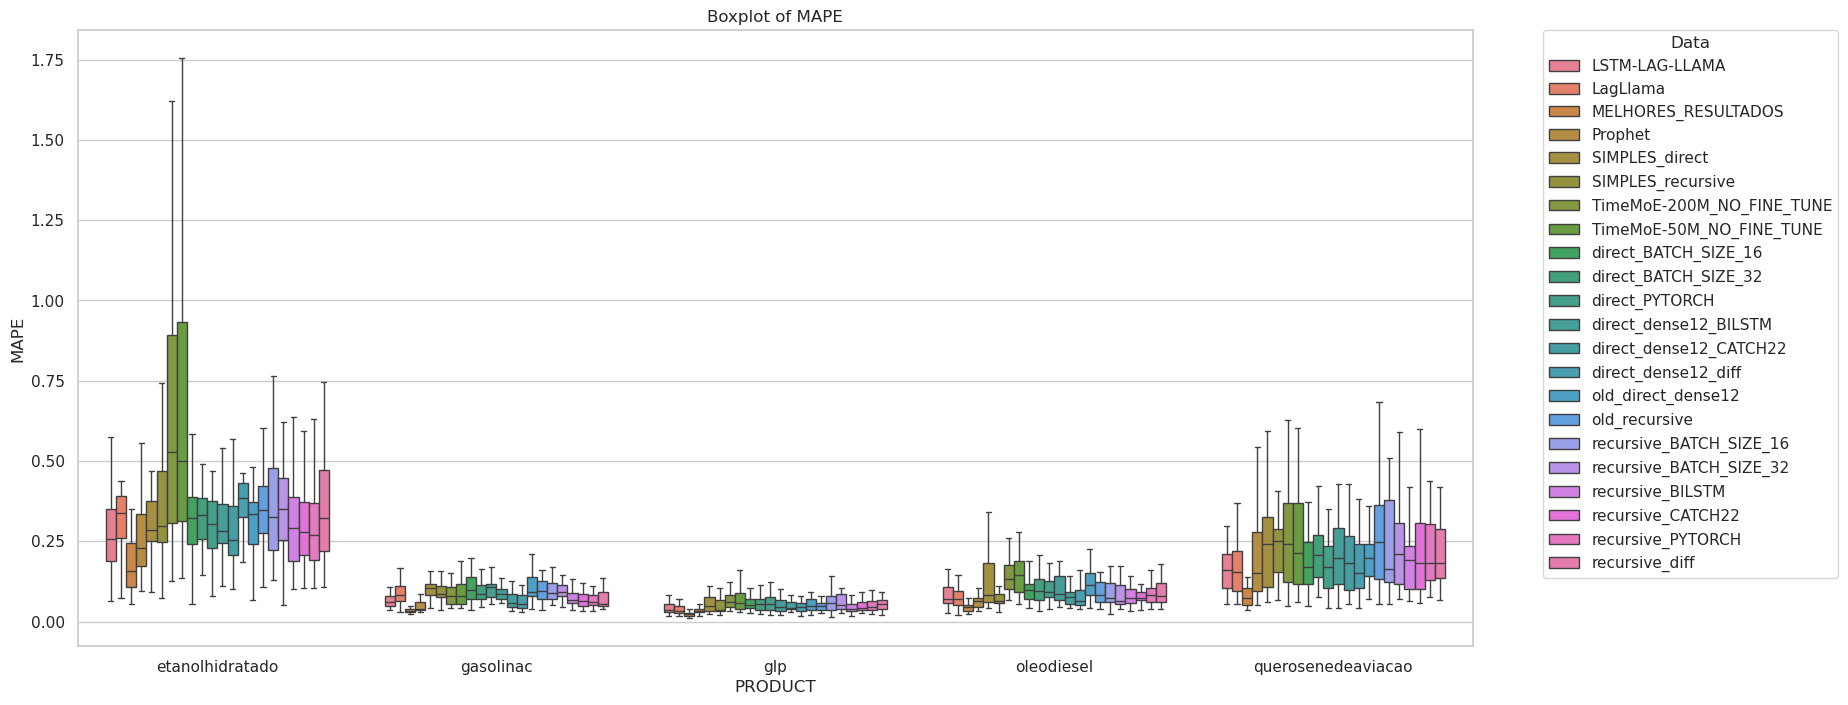

In [17]:
# Setting the aesthetics for the plot
sns.set(style="whitegrid")
 
# Creating the boxplot
plt.figure(figsize=(18, 8))

sorted_hue = sorted(df['TYPE_PREDICTIONS'].unique())

# Generating the boxplot with ordered legends
boxplot = sns.boxplot(x='PRODUCT', y='MAPE', hue='TYPE_PREDICTIONS', data=df, showfliers=False, hue_order=sorted_hue)
boxplot.set_title('Boxplot of MAPE')
 
# Positioning the legend on the right side, outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Data')

plt.show()


/tmp/ipykernel_243314/4264508572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TYPE_PREDICTIONS', y='MAPE', data=product_data,


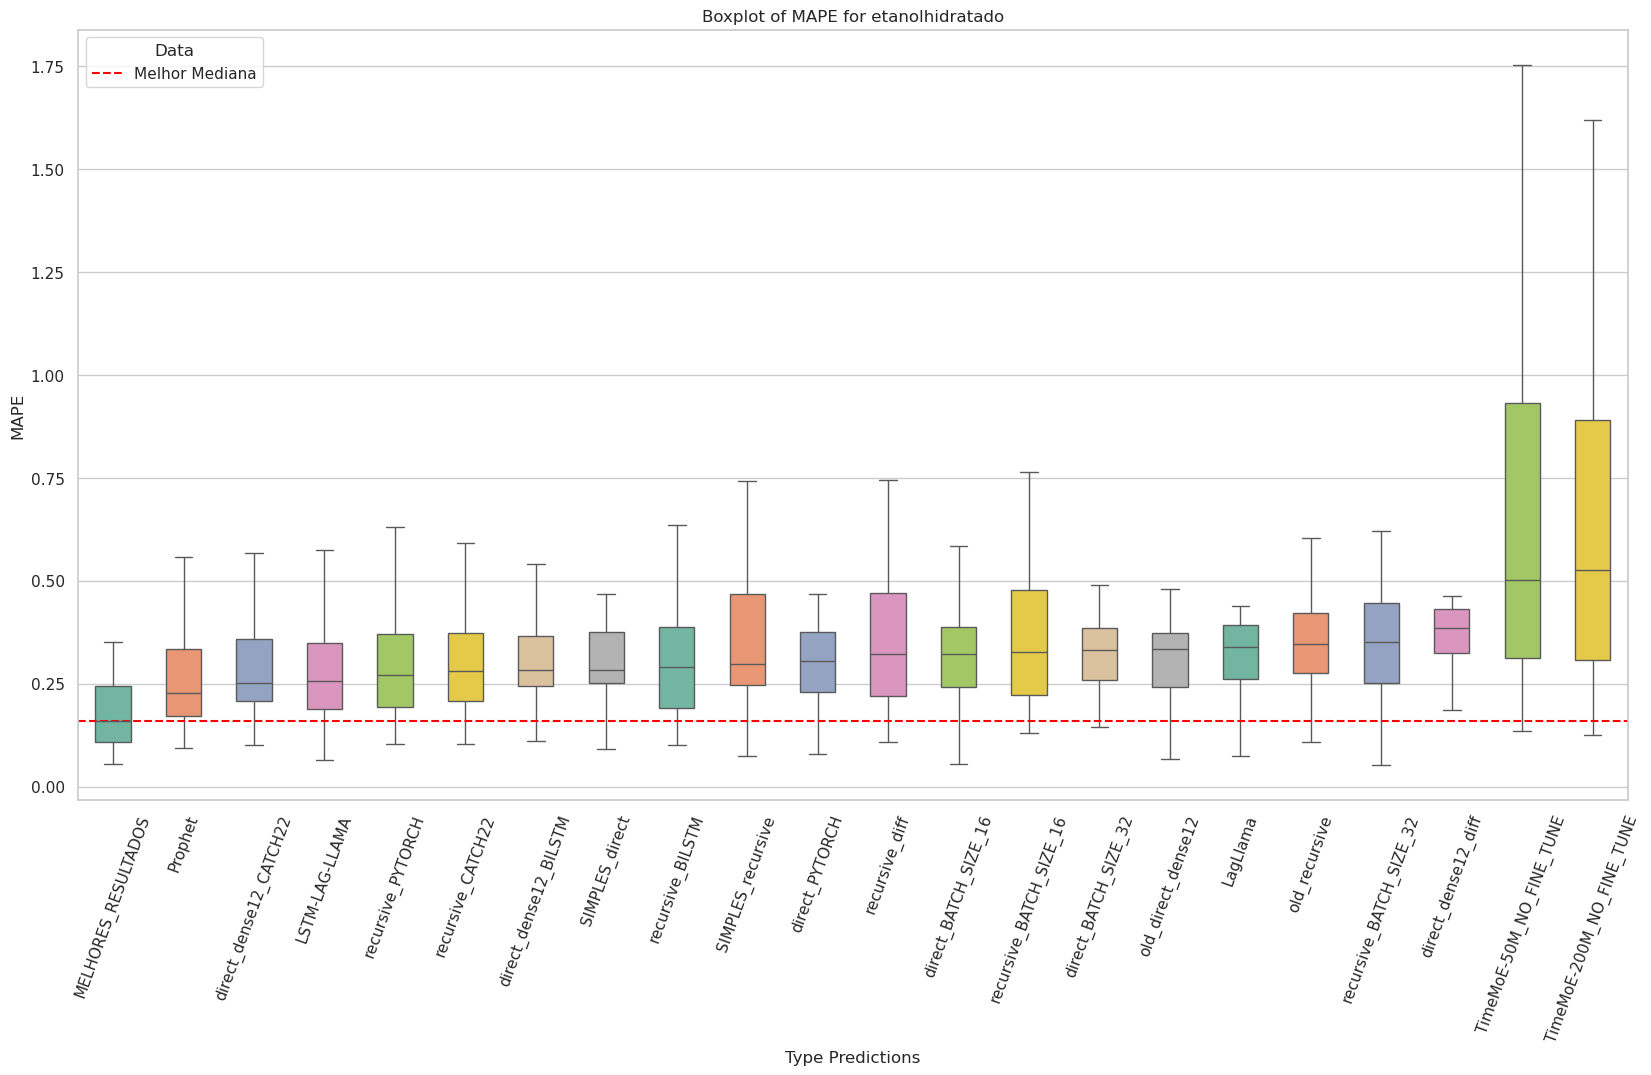

/tmp/ipykernel_243314/4264508572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TYPE_PREDICTIONS', y='MAPE', data=product_data,


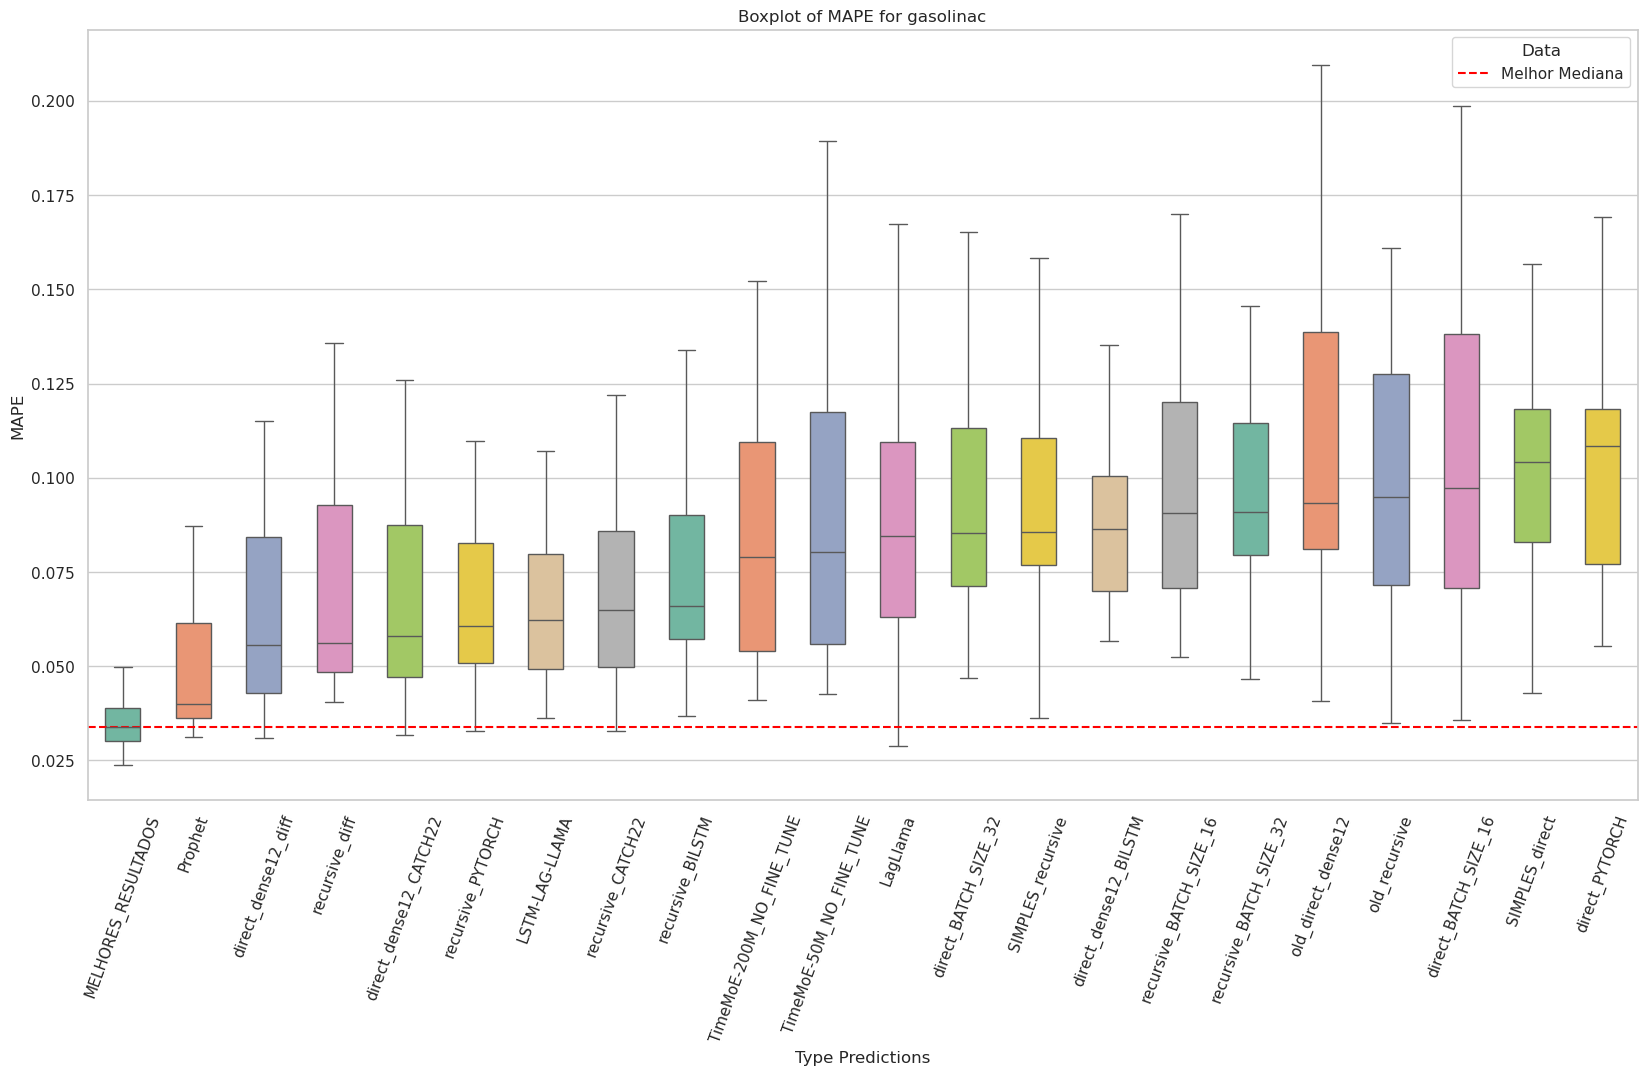

/tmp/ipykernel_243314/4264508572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TYPE_PREDICTIONS', y='MAPE', data=product_data,


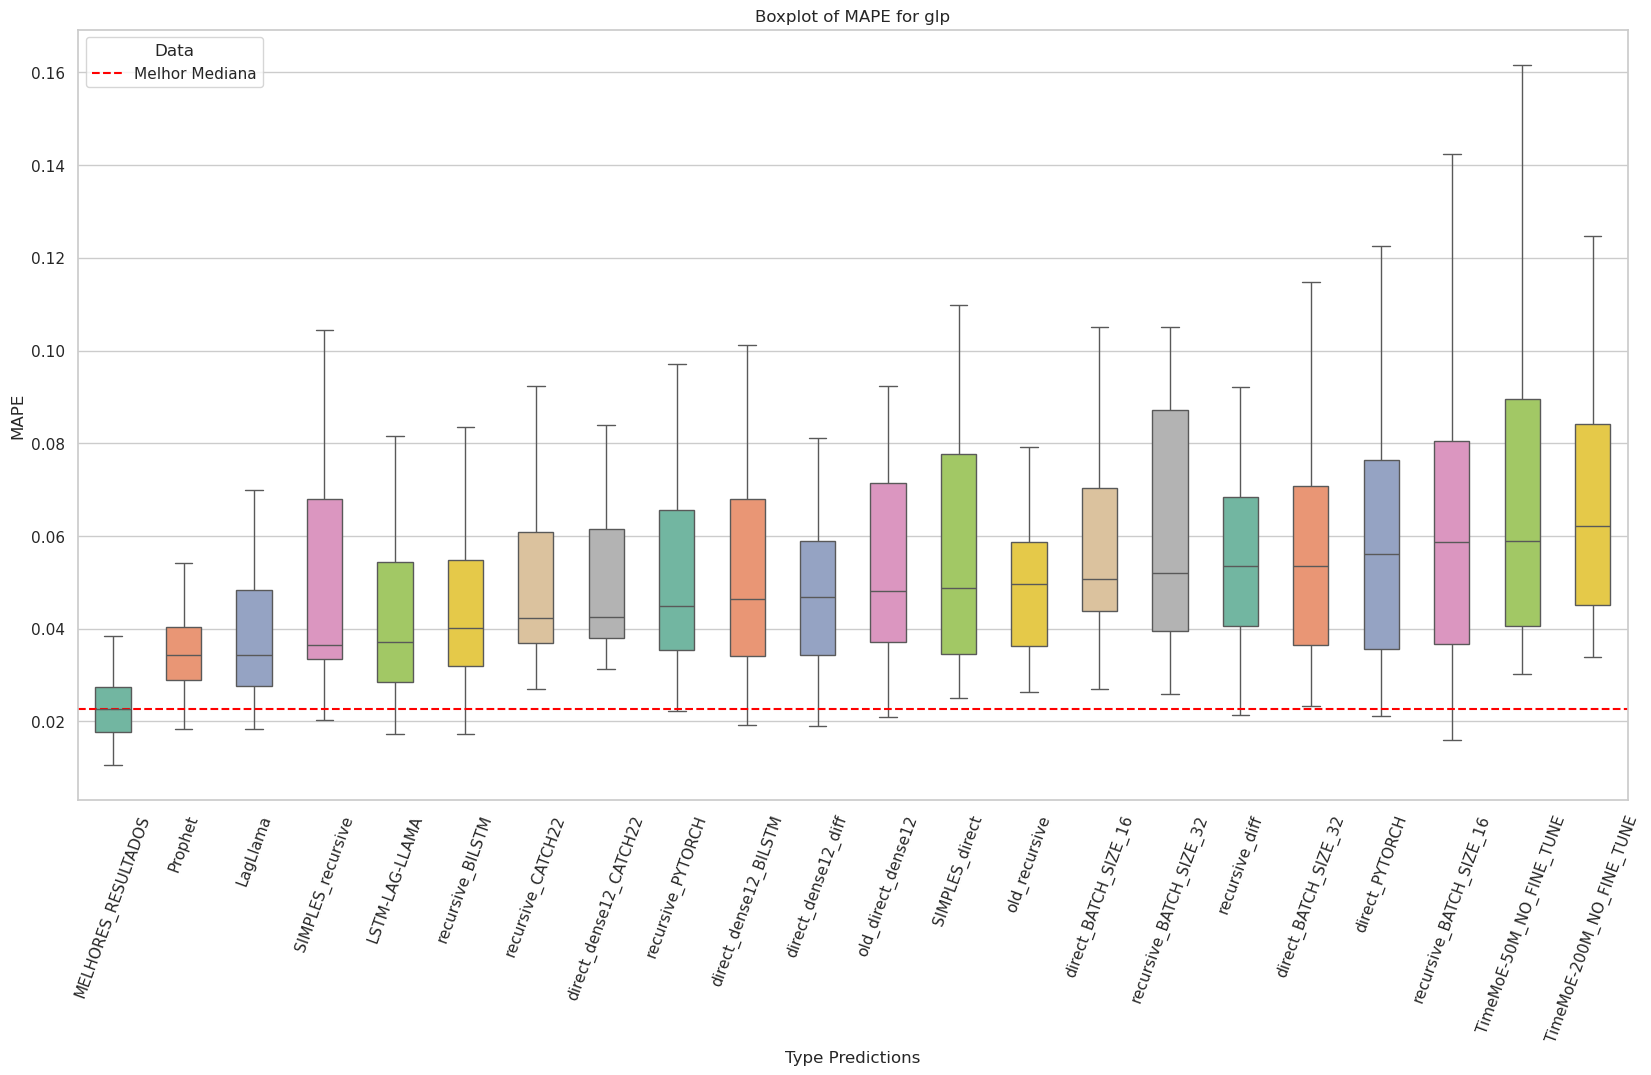

/tmp/ipykernel_243314/4264508572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TYPE_PREDICTIONS', y='MAPE', data=product_data,


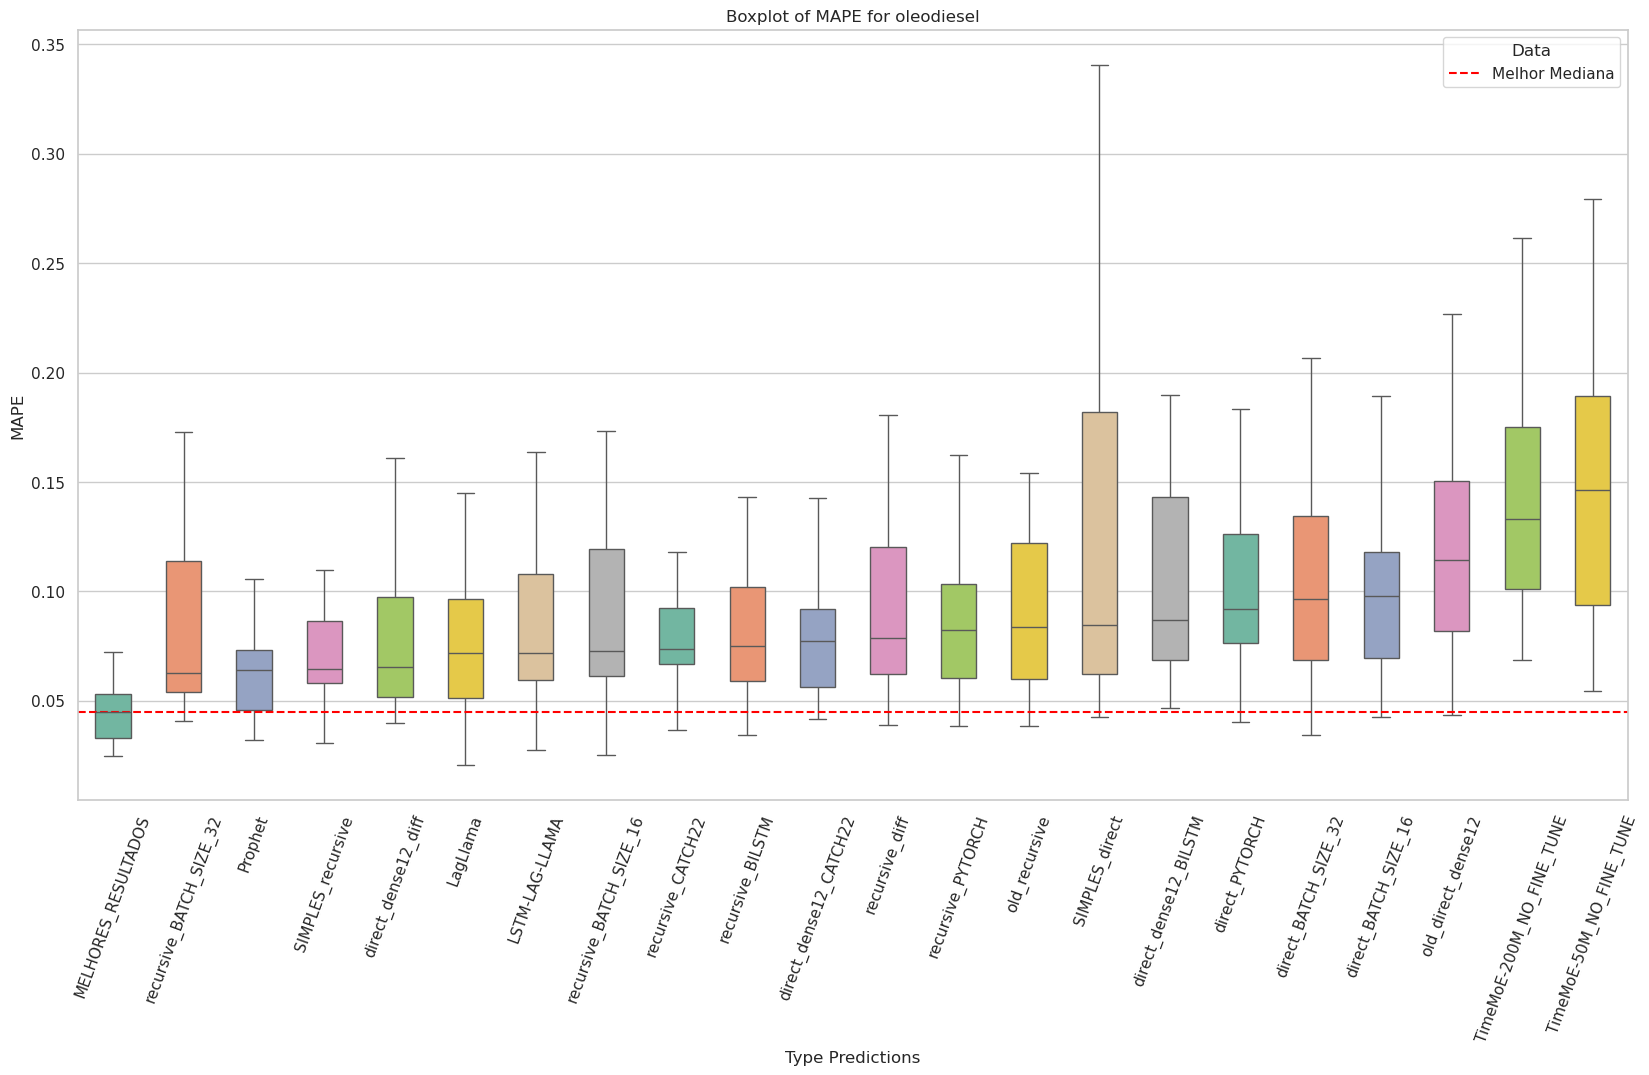

/tmp/ipykernel_243314/4264508572.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TYPE_PREDICTIONS', y='MAPE', data=product_data,


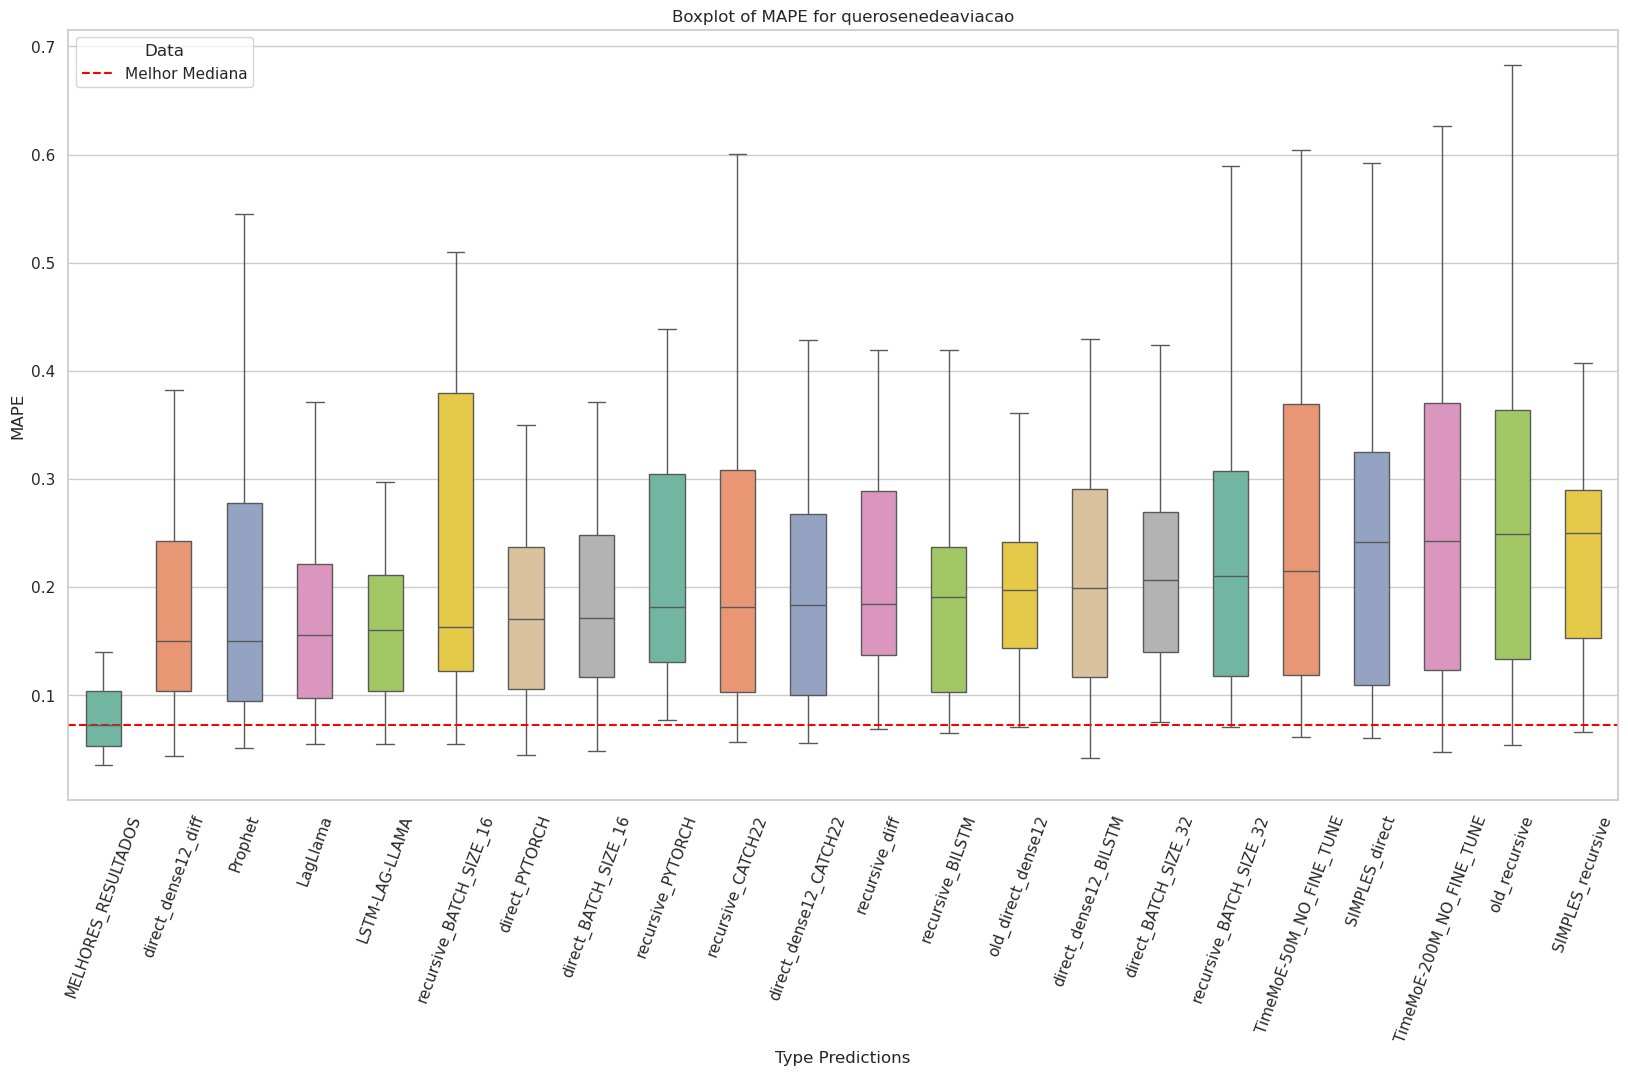

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular a mediana de MAPE para cada combinação de PRODUCT e TYPE_PREDICTIONS
median_mape = df.groupby(['PRODUCT', 'TYPE_PREDICTIONS'])['MAPE'].median().reset_index()

# Para cada PRODUCT, criar uma lista de TYPE_PREDICTIONS ordenados pela mediana
order_dict = {}
best_median_dict = {}
for product in df['PRODUCT'].unique():
    product_median = median_mape[median_mape['PRODUCT'] == product].sort_values(by='MAPE')
    order_dict[product] = product_median['TYPE_PREDICTIONS'].tolist()
    best_median_dict[product] = product_median['MAPE'].min()  # Armazenar a melhor mediana

# Plotar boxplots para cada PRODUCT com a ordem correta
for product in df['PRODUCT'].unique():
    # Criar o boxplot
    plt.figure(figsize=(20, 10))
    
    # Filtrar os dados para o PRODUCT atual
    product_data = df[df['PRODUCT'] == product]
    
    # Criar o boxplot
    sns.boxplot(x='TYPE_PREDICTIONS', y='MAPE', data=product_data, 
                order=order_dict[product], showfliers=False, 
                palette="Set2", 
                width=0.5)
    
    # Adicionar título e rótulos
    plt.title(f'Boxplot of MAPE for {product}')
    plt.xlabel('Type Predictions')
    plt.ylabel('MAPE')
    
    # Adicionar linha pontilhada vermelha na melhor mediana
    plt.axhline(y=best_median_dict[product], color='red', linestyle='--', label='Melhor Mediana')
    
    # Exibir o gráfico
    plt.xticks(rotation=70)
    plt.legend(title='Data')
    plt.show()


### MASE

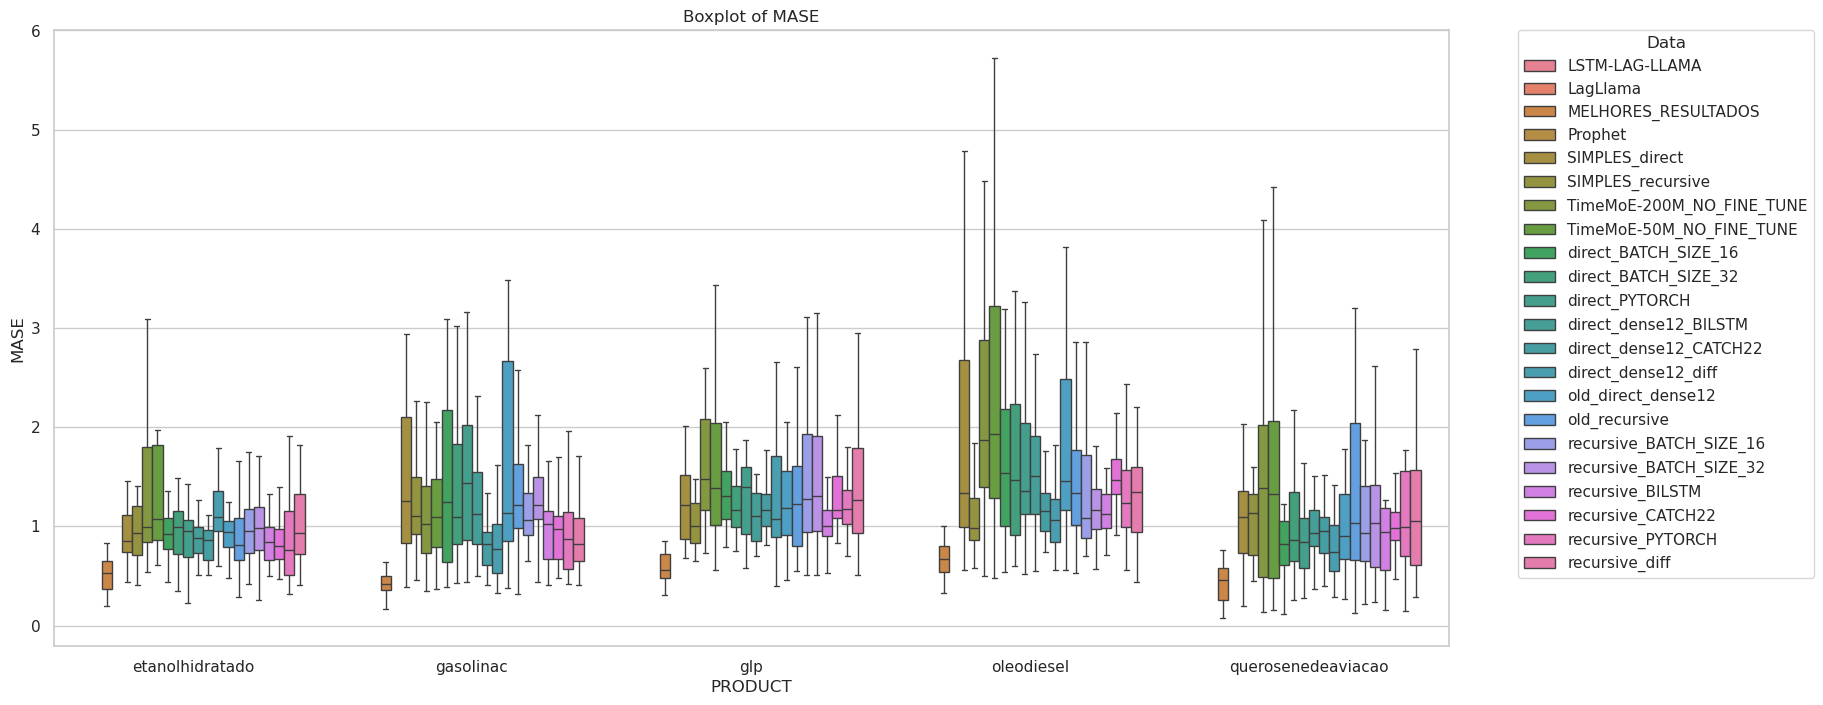

In [19]:
# Setting the aesthetics for the plot
sns.set(style="whitegrid")
 
# Creating the boxplot
plt.figure(figsize=(18, 8))

sorted_hue = sorted(df['TYPE_PREDICTIONS'].unique())

# Generating the boxplot with ordered legends
boxplot = sns.boxplot(x='PRODUCT', y='MASE', hue='TYPE_PREDICTIONS', data=df, showfliers=False, hue_order=sorted_hue)
boxplot.set_title('Boxplot of MASE')
 
# Positioning the legend on the right side, outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Data')

plt.show()


### PBE

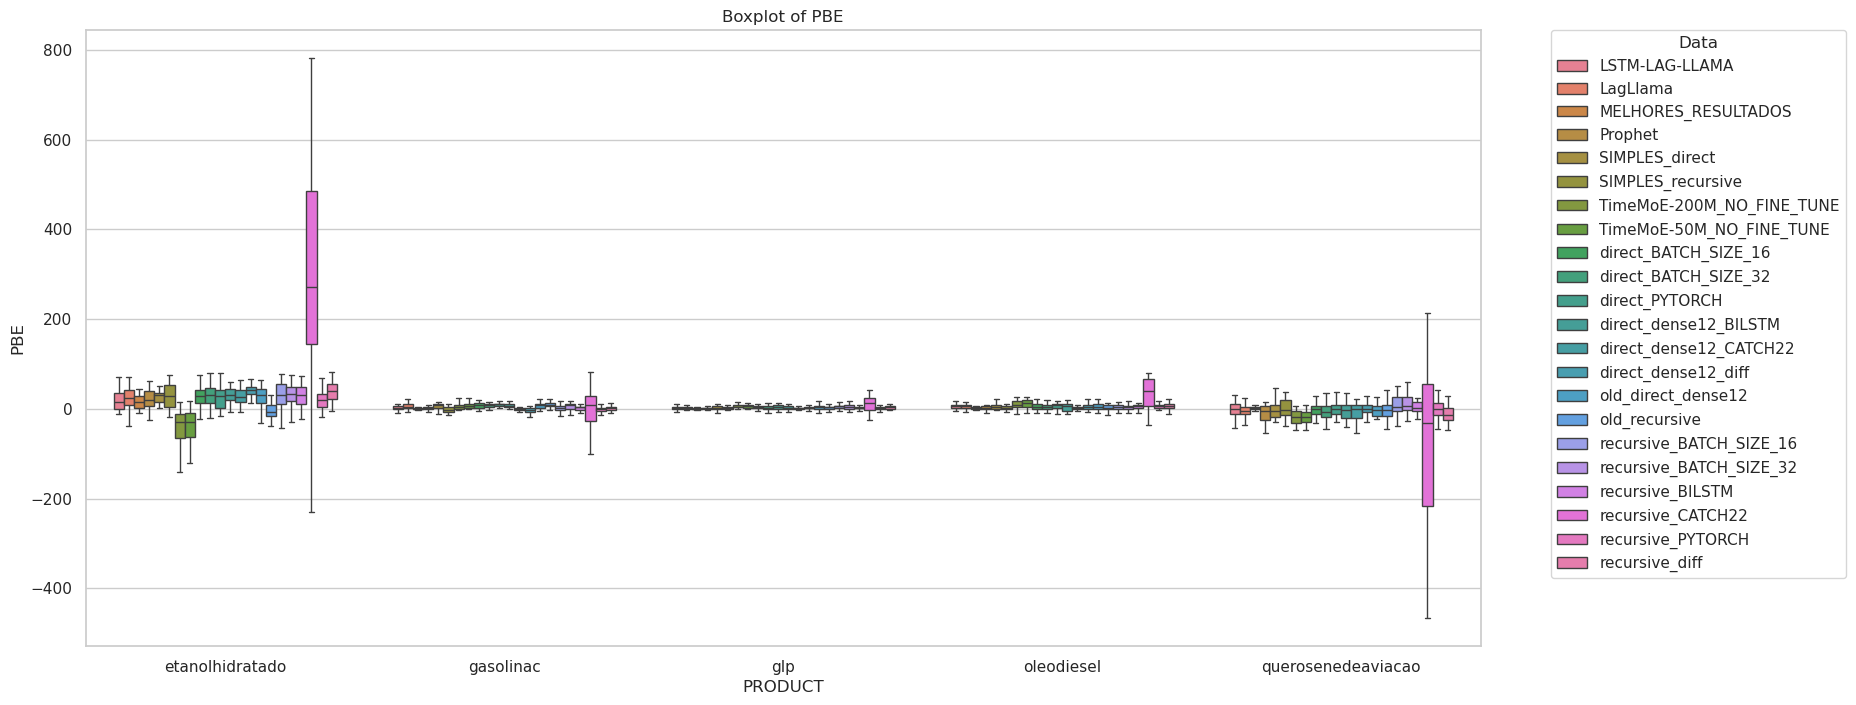

In [20]:
# Setting the aesthetics for the plot
sns.set(style="whitegrid")
 
# Creating the boxplot
plt.figure(figsize=(18, 8))

sorted_hue = sorted(df['TYPE_PREDICTIONS'].unique())

# Generating the boxplot with ordered legends
boxplot = sns.boxplot(x='PRODUCT', y='PBE', hue='TYPE_PREDICTIONS', data=df, showfliers=False, hue_order=sorted_hue)
boxplot.set_title('Boxplot of PBE')
 
# Positioning the legend on the right side, outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Data')

plt.show()


### POCID

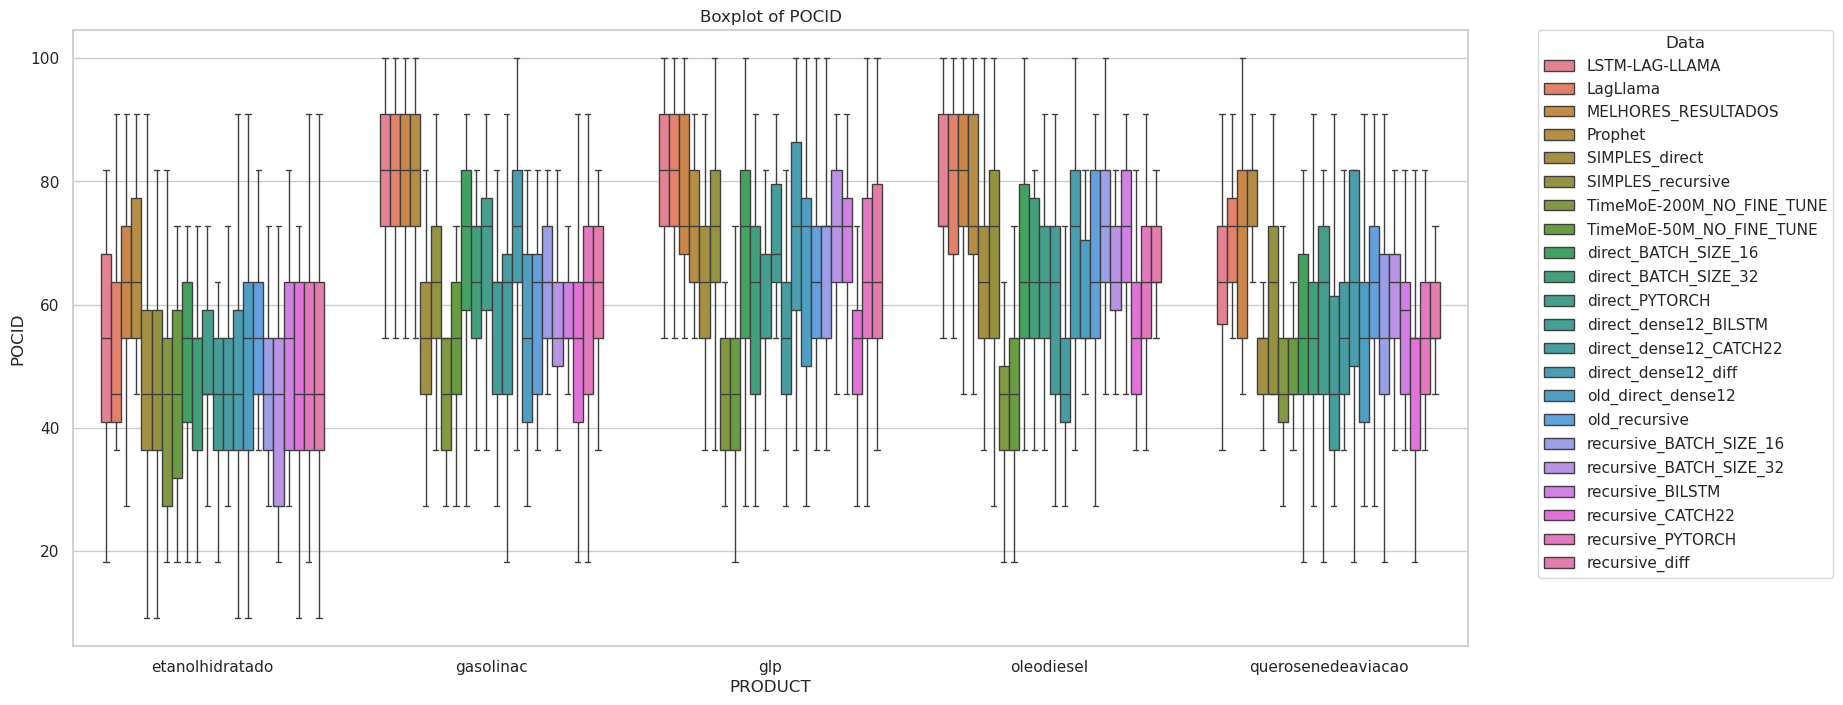

In [21]:
# Setting the aesthetics for the plot
sns.set(style="whitegrid")
 
# Creating the boxplot
plt.figure(figsize=(18, 8))

sorted_hue = sorted(df['TYPE_PREDICTIONS'].unique())

# Generating the boxplot with ordered legends
boxplot = sns.boxplot(x='PRODUCT', y='POCID', hue='TYPE_PREDICTIONS', data=df, showfliers=False, hue_order=sorted_hue)
boxplot.set_title('Boxplot of POCID')
 
# Positioning the legend on the right side, outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Data')

plt.show()
